# Mandatory Assignment 2
## Exercise-1
### Q1.1

In [18]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc

# Load the dataset
data = load_breast_cancer()

print(data.DESCR)


.. _breast_cancer_dataset:

Breast cancer Wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

From using print(data.DESCR) we find a list of feature names that we can use to find the target distribution. The target distribution in question is wether or not a cell nuclei is malignant or benign. For each entry in the dataset we can find if its malignant or not by using data.target[index], it will return a 0 or 1, a 0 is malignant 1 is not.

From the data description we can see that the class distribution is moderately imbalanced. There is more benign cells than malignant cells, this could be the cause for some over and underfittings later in the assignment which could impact the model preformance. 

### Q1.2

C:\Users\Gdwni\AppData\Local\Temp\ipykernel_9464\1498717633.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(X, vert=False, labels=data.feature_names)


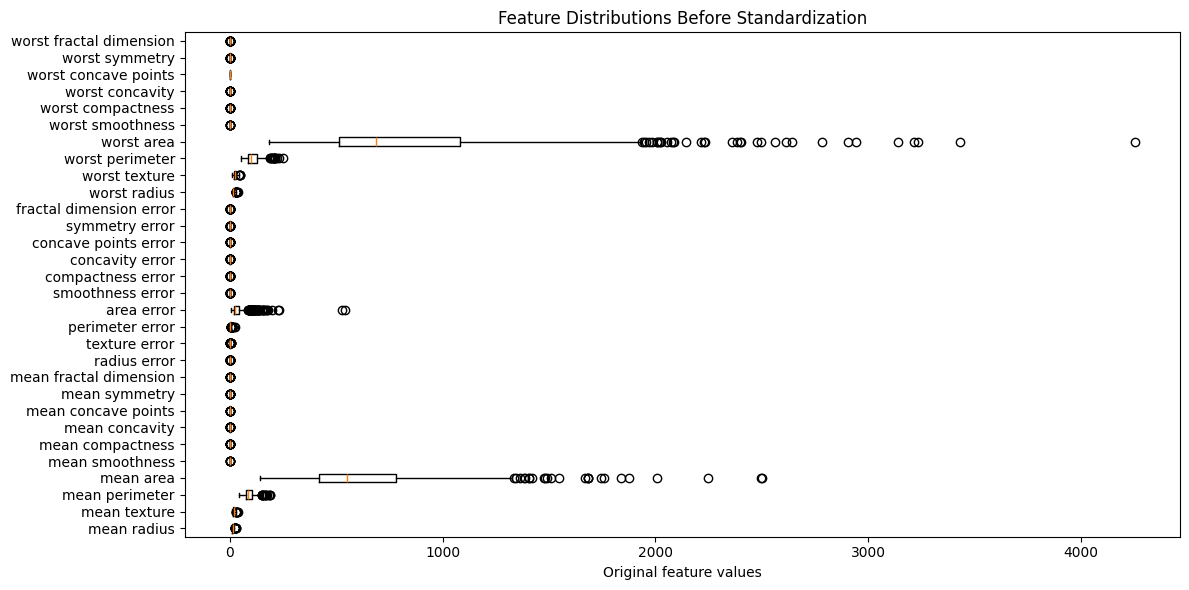

In [19]:
X = pd.DataFrame(data.data, columns= data.feature_names)
# Descriptive statistics
stats_before = X.describe().T[['mean', 'std', 'min', 'max']]

# Visualization: boxplots
plt.figure(figsize=(12, 6))
plt.boxplot(X, vert=False, labels=data.feature_names)
plt.title("Feature Distributions Before Standardization")
plt.xlabel("Original feature values")
plt.tight_layout()
plt.show()

                                mean      std       min       max
mean radius            -3.153111e-15  1.00088 -2.029648  3.971288
mean texture           -6.568462e-15  1.00088 -2.229249  4.651889
mean perimeter         -6.993039e-16  1.00088 -1.984504  3.976130
mean area              -8.553985e-16  1.00088 -1.454443  5.250529
mean smoothness         6.081447e-15  1.00088 -3.112085  4.770911
mean compactness       -1.136369e-15  1.00088 -1.610136  4.568425
mean concavity         -2.997017e-16  1.00088 -1.114873  4.243589
mean concave points     1.023981e-15  1.00088 -1.261820  3.927930
mean symmetry          -1.860648e-15  1.00088 -2.744117  4.484751
mean fractal dimension -1.504752e-15  1.00088 -1.819865  4.910919


C:\Users\Gdwni\AppData\Local\Temp\ipykernel_9464\2301100401.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(X_scaled, vert=False, labels=data.feature_names)


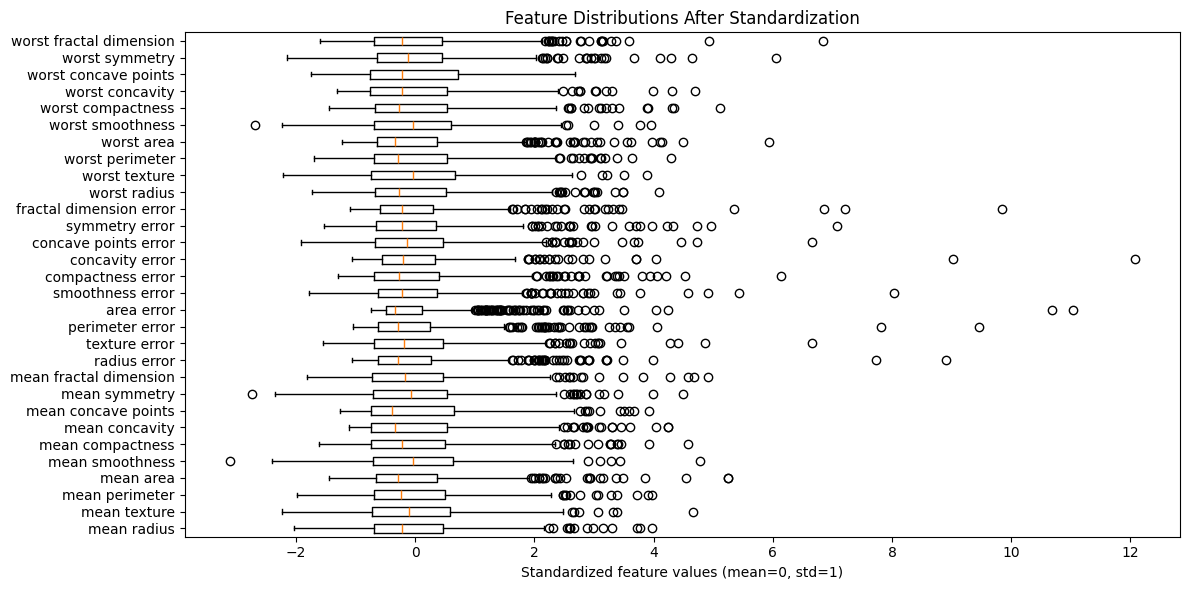

In [20]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=data.feature_names)

# Descriptive statistics
stats_after = X_scaled.describe().T[['mean', 'std', 'min', 'max']]
print(stats_after.head(10))

# Visualization: boxplots
plt.figure(figsize=(12, 6))
plt.boxplot(X_scaled, vert=False, labels=data.feature_names)
plt.title("Feature Distributions After Standardization")
plt.xlabel("Standardized feature values (mean=0, std=1)")
plt.tight_layout()
plt.show()


As we can see from the 2 different plots, the visuals varies wildly based on what feature we are talking about. For many distance-based models, we would prefer a more standardized dataset, so one feature doesnt dominates due to its size. 
### Q1.3
A three way split is vital for a models robustness to real world data. With the training set we can learn internal parameters, with the validation set we can tune hyperparameters and find the one that suits the model best, and with the test set we can keep learning seperate from the real data, making the model even more robust. 

Keeping all of these parts separate wont necessarily make the results we see better, but it will make the real world preformance (robustness) more accurate, which is what we want.

## Exercise-2
### Q2.1


In [21]:
# Assign variables to be used further in the code
X, y = data.data, data.target
# Scales the dataset

feature_names = data.feature_names
target_names = data.target_names

# Function for splitting the dataset, just for future use
def split_dataset(X, y):
    # Test set (20%)
    X_tmp, X_test, y_tmp, y_test = train_test_split(
        X,y, test_size=0.20, stratify=y, random_state=20
    )

    #Training and validation set
    # Test_size is 0.25 here because it would be 20% of the total dataset since we already subtracted 20% from the test set.
    X_train, X_val, y_train, y_val = train_test_split(
        X_tmp, y_tmp, test_size=0.25, stratify=y_tmp, random_state=20
    )
    
    # Standardize using *only* the training data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return X_test, y_test, X_val, y_val, X_train, y_train


X_test, y_test, X_val, y_val, X_train, y_train = split_dataset(X,y)

print("Train/Val/Test:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

cv = StratifiedKFold(n_splits=5)


model = DecisionTreeClassifier(random_state=1)

scores = cross_val_score(model, X_train, y_train)

print(f"DecisionTree default params CV accuracy: mean= {scores.mean():.3f}, std= {scores.std():.3f}")

model.fit(X_train, y_train)
val_pred = model.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)
print(f"DecisionTree default params Validation acc: {val_acc:.3f}")

Train/Val/Test: 341 114 114
DecisionTree default params CV accuracy: mean= 0.906, std= 0.029
DecisionTree default params Validation acc: 0.921


We can see that across the 5 folds we did we had an accuracy of 0.906 and a standard deviation of 0.029, this is without any tuning of the model.

### Q2.2

1. worst perimeter: 0.7337
2. worst concave points: 0.0724
3. worst texture: 0.0681


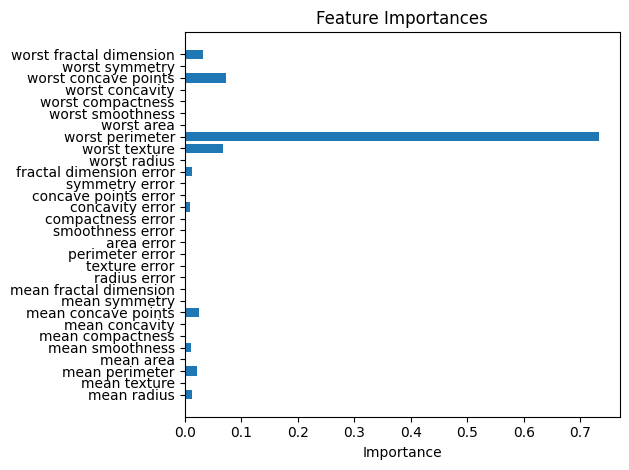

In [22]:
top_features = np.argsort(model.feature_importances_)[::-1]
for i in range(3):
    print(f"{i+1}. {feature_names[top_features[i]]}: {model.feature_importances_[top_features[i]]:.4f}")


plt.barh(feature_names,model.feature_importances_, orientation='horizontal')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

As we can see from the print out, the 3 features that tells the model if a cell is malignant or not is: worst perimiter, worst concave points and worst texture.

The feature importance values here is extremely centered on one point, the worst perimiter. This can mean many things, but one thing it may hint at is that the model is over relying on this one feature to detect malignant cells. As we can see in the accuracy of the model, it does catch most cases, however for some edgecases, it may overrely on the perimiter size and mistake a malignant small cell for a benign cell.

### Q2.3

Depth 2: mean=0.903, std=0.023
Depth 3: mean=0.909, std=0.039
Depth 4: mean=0.918, std=0.024
Depth 5: mean=0.909, std=0.017
Depth 6: mean=0.909, std=0.017
Depth 7: mean=0.909, std=0.017
Depth 8: mean=0.909, std=0.017
Depth 9: mean=0.909, std=0.017
Depth 10: mean=0.909, std=0.017


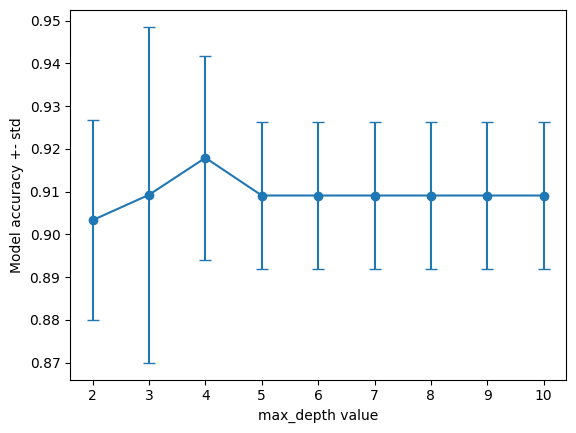

In [23]:
# I think this is redundant, but it did change the results quite a bit
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


depths = range(2, 11)  # 2 to 10 inclusive
mean_scores = []
std_scores = []

# Run through the different depths, save the results and plot them out.
for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=1)
    scores = cross_val_score(model, X_train, y_train, cv=cv)
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())
    print(f"Depth {d}: mean={scores.mean():.3f}, std={scores.std():.3f}")

plt.errorbar(depths, mean_scores, yerr=std_scores, fmt='-o', capsize=4)
plt.xlabel("max_depth value")
plt.ylabel("Model accuracy +- std")
plt.show()

From the resulting tests we can see that the max_depth value most suitable for our model would be 4. It has the highest accuracy with the lowest deviation. 

The reason why we see these results would be because of over and underfitting. If the max_depth is too low, the model would be too simple and would underfit, it cant capture the relationships between features. If the max_depth is too high, the model could overfit.

### Q2.4

Leaf 2: mean=0.915, std=0.025
Leaf 3: mean=0.918, std=0.035
Leaf 4: mean=0.915, std=0.031
Leaf 5: mean=0.912, std=0.030
Leaf 6: mean=0.918, std=0.027
Leaf 7: mean=0.924, std=0.031
Leaf 8: mean=0.921, std=0.030
Leaf 9: mean=0.927, std=0.024
Leaf 10: mean=0.918, std=0.025


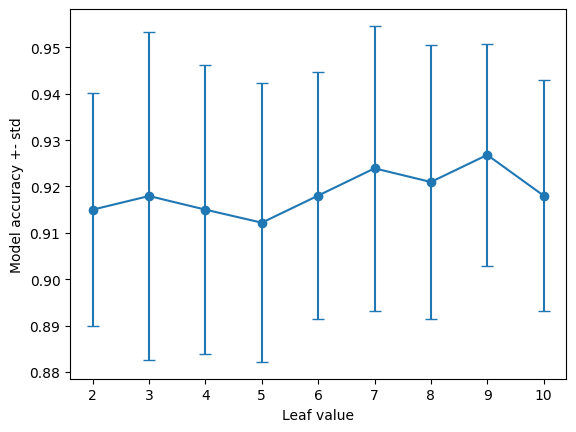

In [24]:
# I think this is redundant, but it did change the results quite a bit
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


leafs = range(2, 11)
mean_scores = []
std_scores = []

# Run through the different Leafs, save the results and plot them out.
for l in leafs:
    model = DecisionTreeClassifier(min_samples_leaf=l,max_depth=4, random_state=1)
    scores = cross_val_score(model, X_train, y_train, cv=cv)
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())
    print(f"Leaf {l}: mean={scores.mean():.3f}, std={scores.std():.3f}")

plt.errorbar(leafs, mean_scores, yerr=std_scores, fmt='-o', capsize=4)
plt.xlabel("Leaf value")
plt.ylabel("Model accuracy +- std")
plt.show()

In [25]:
model = DecisionTreeClassifier(min_samples_leaf=l,max_depth=4, random_state=1)
scores = cross_val_score(model, X_train, y_train, cv=cv)
DTCavg = scores.mean()
DTCstd = scores.std()

From the graph we can see that the accuracy peaks at around 7-9 leafs.

## Exercise-3

### Q3.1

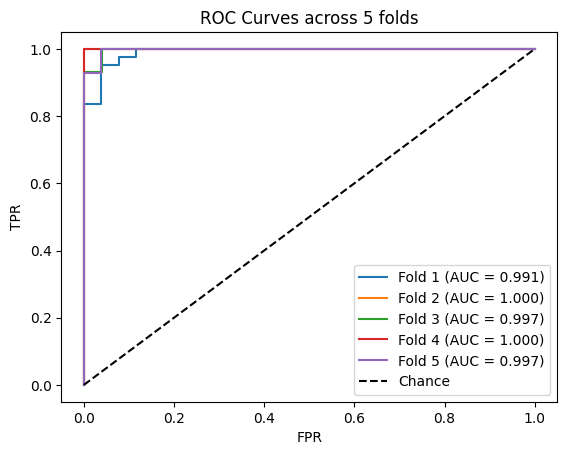

Accuracy: mean=0.971, std=0.009
AUC: mean=0.997, std=0.003


In [26]:
accuracies = []
fprs, tprs, aucs = [], [], []

# Iterate through the 5 folds
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), start=1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Train Linear SVM
    model = SVC(kernel="linear", probability=True, random_state=1)
    model.fit(X_tr, y_tr)

    # Predict on validation set
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]  # needed for ROC curve

    # Accuracy
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.3f})")

# Plot ROC curves
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curves across 5 folds")
plt.legend(loc="lower right")
plt.show()

# Report performance summary
mean_acc_svml = np.mean(accuracies)
std_acc_svml = np.std(accuracies)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

print(f"Accuracy: mean={mean_acc_svml:.3f}, std={std_acc_svml:.3f}")
print(f"AUC: mean={mean_auc:.3f}, std={std_auc:.3f}")


### Q3.2

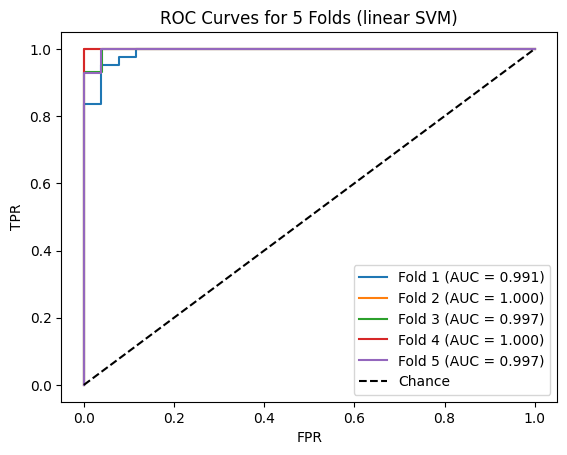

linear SVM → Accuracy: mean=0.971, std=0.009
linear SVM → AUC: mean=0.997, std=0.003



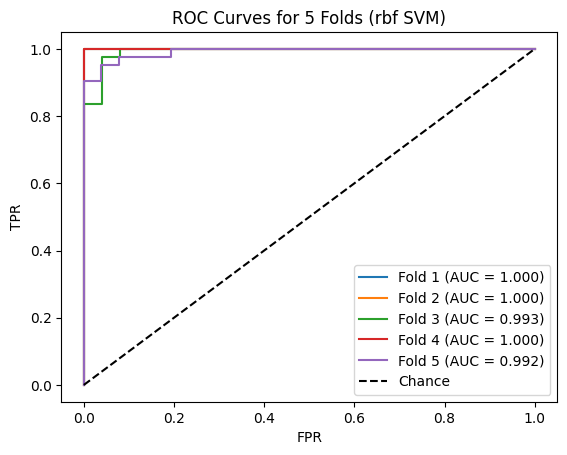

rbf SVM → Accuracy: mean=0.979, std=0.018
rbf SVM → AUC: mean=0.997, std=0.004



In [27]:
mean_acc_svm = 0.971
std_acc_svm = 0.009

def evaluate_svm(kernel_type, X, y):
    accuracies = []
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), start=1):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = SVC(kernel=kernel_type, probability=True, random_state=1)
        model.fit(X_tr, y_tr)

        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)

        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Chance")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC Curves for 5 Folds ({kernel_type} SVM)")
    plt.legend(loc="lower right")
    plt.show()

    mean_acc_svm = np.mean(accuracies)
    std_acc_svm = np.std(accuracies)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    print(f"{kernel_type} SVM → Accuracy: mean={mean_acc_svm:.3f}, std={std_acc_svm:.3f}")
    print(f"{kernel_type} SVM → AUC: mean={mean_auc:.3f}, std={std_auc:.3f}\n")

# Run both
evaluate_svm("linear", X_train, y_train)
evaluate_svm("rbf", X_train, y_train)

### Q3.3

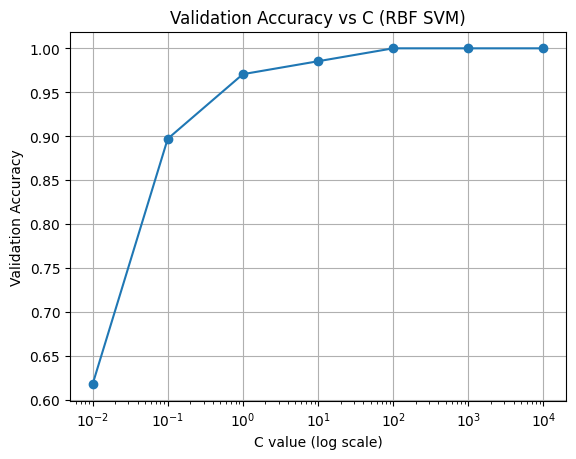

In [28]:
C_values = [0.01, 0.1, 1, 10, 100, 1000, 10000]
val_accuracies = []

for C in C_values:
    model = SVC(kernel="rbf", C=C)
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, val_pred)
    val_accuracies.append(acc)

plt.semilogx(C_values, val_accuracies, '-o')
plt.xlabel("C value (log scale)")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs C (RBF SVM)")
plt.grid(True)
plt.show()


It seems to plateau at around 100 in C value

### Q3.4

γ=0.001: validation accuracy = 0.912
γ=0.01: validation accuracy = 0.971
γ=0.1: validation accuracy = 0.971
γ=1: validation accuracy = 1.000
γ=10: validation accuracy = 1.000
γ=100: validation accuracy = 1.000
γ=1000: validation accuracy = 1.000
γ=10000: validation accuracy = 1.000


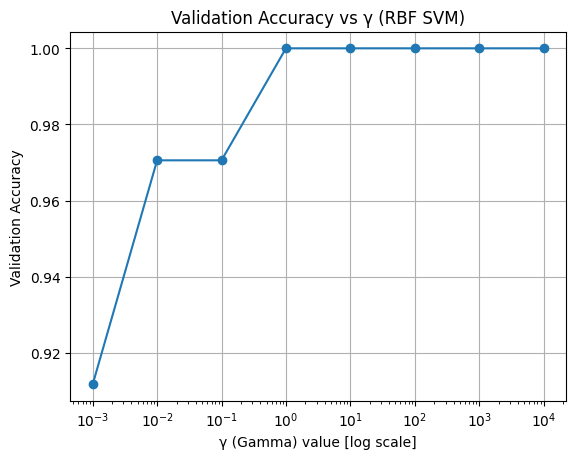

Best γ = 1 with validation accuracy = 1.000


In [29]:
gamma_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
val_accuracies = []

for g in gamma_values:
    model = SVC(kernel="rbf", gamma=g, C=1)
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, val_pred)
    val_accuracies.append(acc)
    print(f"γ={g}: validation accuracy = {acc:.3f}")

# Plot results
plt.semilogx(gamma_values, val_accuracies, '-o')
plt.xlabel("γ (Gamma) value [log scale]")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs γ (RBF SVM)")
plt.grid(True)
plt.show()

# Find best gamma
best_gamma = gamma_values[np.argmax(val_accuracies)]
best_acc = np.max(val_accuracies)
print(f"Best γ = {best_gamma} with validation accuracy = {best_acc:.3f}")

Small gamma values will result in a smaller gaussian kernel, a small kernel will not be able to capture patterns all that well, it will have high bias and low variance. A high gamma value would have low bias and high variance, and would be very sensitive to noise in the dataset. A balanced gamma value will have a little bit of both, and will be able to generalize well. Even though the accuracy is through the roof in the graphs here, it will be because of overfitting. 

## Exercise-4

### Q4.1

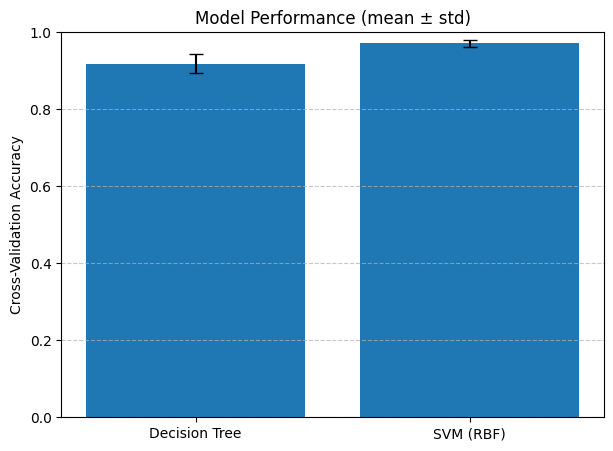

In [30]:
models = ['Decision Tree', 'SVM (RBF)']
means = [DTCavg, mean_acc_svm]
stds  = [DTCstd,std_acc_svm]

plt.figure(figsize=(7,5))
plt.bar(models, means, yerr=stds, capsize=5)
plt.ylabel("Cross-Validation Accuracy")
plt.title("Model Performance (mean ± std)")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Looking at the bar plots, we can see that the SVM preformes better than the devision tree on the training set. We can assume that this means that it would generelize better, but we cannot be for certain before trying it on the test set.

### Q4.2
For medical decision-support system, we want the model to be as accurate as possible, however we also want to understand why the model came to its conclusion. Just saying that a patient has a malignant cell would provide little insight into what medical conclusions played a part of this. For that reason, SVM would behave kinda like a black box, it would be highly accurate, but would be of little use to doctors trying to understand why a patient has a malignant cell. For this reason i would probably go with decision tree, solely because its easier to see why it came to its conclusion.

### Q4.3

In [31]:
# --- Decision Tree ---
dt_params = {
    'max_depth': [2, 3, 4, 5, 6, 8, 10],
    'min_samples_split': [2,3,4,5,6,7,8,9,10],
}

dt = DecisionTreeClassifier(random_state=1)
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train, y_train)

best_dt = dt_grid.best_estimator_
print("Best Decision Tree parameters:", dt_grid.best_params_)

# Evaluate on validation set
y_val_pred_dt = best_dt.predict(X_val)
dt_val_acc = accuracy_score(y_val, y_val_pred_dt)
print(f"Decision Tree Validation Accuracy: {dt_val_acc:.3f}")


Best Decision Tree parameters: {'max_depth': 2, 'min_samples_split': 2}
Decision Tree Validation Accuracy: 0.971


In [32]:
# --- SVM (RBF kernel) ---
svm_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

svm = SVC(probability=True, random_state=1)
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

best_svm = svm_grid.best_estimator_
print("Best SVM parameters:", svm_grid.best_params_)

# Evaluate on validation set
y_val_pred_svm = best_svm.predict(X_val)
svm_val_acc = accuracy_score(y_val, y_val_pred_svm)
print(f"SVM Validation Accuracy: {svm_val_acc:.3f}")


Best SVM parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVM Validation Accuracy: 0.971


### Q4.4

In [34]:
pred_test_svm = svm_grid.fit(X_test, y_test)
pred_test_svm_acc = accuracy_score(y_val, y_val_pred_svm)
print(f"SVM test accuracy: {pred_test_svm_acc:.3f}")


SVM test accuracy: 0.971


In [ ]:
pred_test_dt = dt_grid.fit(X_test, y_test)
pred_test_dt_acc = accuracy_score(y_val, y_val_pred_dt)
print(f"DT test accuracy: {pred_test_dt_acc:.3f}")

SVM test accuracy: 0.971


There seem to be no differences in the model according to the accuracy report. In practice then it would be best to use DT for the transparency 

### Q4.5
When a dataset has overlapping or curved class boundaries, a linear SVM is too restrictive.
It assumes that the two classes can be divided by a flat boundary, which leads to underfitting, the model cannot adapt to the complex shape of the data distribution.
A linear svm tries to find the best straight hyperplane that maximizes the margin between classes. However if the datapoints of different classes are intertwined that margin will misclassify many points and fail to represent local structures in the data.

An RBF kerner maps the input data from the original 30-dimensional feature space into a much higher dimensional space. In this new space the model can construct non-linear decisions that bend and wrap around the data clusters. 